In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from PIL import ImageFilter as Filter

In [2]:
def edge_enhancing(array):
    method = np.random.choice(['ada_thold', 'laplacian', 'edge_enahnced'])
    
    if method=='ada_thold':     
        return np.expand_dims(cv2.adaptiveThreshold(array, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1), 2)
    
    elif method=='laplacian':
        return np.expand_dims(cv2.Laplacian(array,cv2.CV_64F, ksize=5), 2)
    
    else:
        image = Image.fromarray(np.squeeze(array, axis=2)).convert('L')
        return np.expand_dims(np.asarray(image.filter(Filter.EDGE_ENHANCE_MORE)), 2)

In [3]:
def de_texturization(array):
    n = np.random.choice([5, 9, 13, 15])
    sigma = np.random.choice([50, 65, 75])
    
    return np.expand_dims(cv2.bilateralFilter(array, n, sigma, sigma), 2)

In [4]:
def random_flip(array):    
    if random.choice([True, False]):
        return tf.image.random_flip_left_right(array).numpy()
    else:
        return tf.image.random_flip_up_down(array).numpy()

In [5]:
def tumbnail(array, shape=(512,512)):
    return cv2.resize(array, shape) 

In [6]:
def random_crop(array):
    method = np.random.choice(['left', 'right', 'top', 'down'])
    v_center = array.shape[1]//2
    h_center = array.shape[0]//2
    
    if method == 'left':
        return array[:,:v_center,:]
    elif method == 'right':
        return array[:,v_center:,:]
    elif method == 'top':
        return array[:h_center,:,:]
    elif method == 'down':
        return array[h_center:,:,:]
    else:
        return array

In [7]:
def pre_processing(image, input_size=224):
    img = np.array(image)
    
    # Optional de-texturize and crop
    if np.random.rand() < 0.5:
        img = de_texturization(img)
        img = edge_enhancing(img)
    
    img = tumbnail(img, (input_size, input_size))
    
    # Convert to 3 channels if grayscale
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)  # make it (H, W, 1)
        img = np.repeat(img, 3, axis=2)    # then to (H, W, 3)
    elif img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    
    img = img.astype(np.float32) / 255.0  # normalize to [0,1]
    img = np.transpose(img, (2, 0, 1))     # to (C, H, W)
    return torch.tensor(img)

In [8]:
train_df = pd.read_csv('data/train_df.csv', usecols=['image_path', 'Target'])
train_df

,Target,image_path
0,0,./images/train/1.2.826.0.1.3680043.8.498.10025...
1,15,./images/train/1.2.826.0.1.3680043.8.498.10036...
2,12,./images/train/1.2.826.0.1.3680043.8.498.10038...
3,14,./images/train/1.2.826.0.1.3680043.8.498.10050...
4,3,./images/train/1.2.826.0.1.3680043.8.498.10053...
...,...,...
1733,14,./images/train/1.2.826.0.1.3680043.8.498.99711...
1734,11,./images/train/1.2.826.0.1.3680043.8.498.99727...
1735,3,./images/train/1.2.826.0.1.3680043.8.498.99935...
1736,2,./images/train/1.2.826.0.1.3680043.8.498.99969...


In [9]:
train_df['Target'] = train_df['Target'].str.strip()
train_df['image_path'] = train_df['image_path'].apply(lambda x: os.path.join("data", x.lstrip("./")))
train_df


,Target,image_path
0,0,data\images/train/1.2.826.0.1.3680043.8.498.10...
1,15,data\images/train/1.2.826.0.1.3680043.8.498.10...
2,12,data\images/train/1.2.826.0.1.3680043.8.498.10...
3,14,data\images/train/1.2.826.0.1.3680043.8.498.10...
4,3,data\images/train/1.2.826.0.1.3680043.8.498.10...
...,...,...
1733,14,data\images/train/1.2.826.0.1.3680043.8.498.99...
1734,11,data\images/train/1.2.826.0.1.3680043.8.498.99...
1735,3,data\images/train/1.2.826.0.1.3680043.8.498.99...
1736,2,data\images/train/1.2.826.0.1.3680043.8.498.99...


In [10]:
multi_labels = [i for i, target in enumerate(train_df['Target']) if len(target) > 2]
len(multi_labels)


132

In [11]:
corrected_labels = []

for ml in multi_labels:    
    corrected_labels.append([train_df.loc[ml, 'image_path'], train_df.loc[ml, 'Target'].split(' ')[0]])
    
train_df = pd.concat([train_df.drop(train_df.loc[multi_labels].index),
                     pd.DataFrame(corrected_labels, columns=['image_path', 'Target'])], ignore_index=True)


In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df[['image_path', 'Target']], test_size=0.2)
train.shape, test.shape


((1390, 2), (348, 2))

In [13]:
# Step 1: Dataset and DataLoader
class XrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns "Target" and "image_path".
            transform (callable, optional): Transform to be applied on an image.
        """
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = int(self.df.iloc[idx]['Target'])
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        img_tensor = pre_processing(img)
        return img_tensor, label


train_dataset = XrayDataset(train)  # Don't pass transform
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = XrayDataset(test)    # Same here
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
# Step 2: CNN Model Definition
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=16):
        """
        Args:
            num_classes (int): Number of target classes.
        """
        super(CNNClassifier, self).__init__()
        # Using padding to keep spatial dimensions, then reducing with pooling.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adaptive pooling to get a fixed feature size regardless of the input dimensions.
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 56, 56]
        x = self.avgpool(x)                   # [batch, 64, 7, 7]
        x = x.view(x.size(0), -1)             # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                     # logits output
        return x

# Determine the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# It's a good idea to automatically determine the number of classes.
num_classes = train_df["Target"].nunique()  
model = CNNClassifier(num_classes=num_classes).to(device)

# Step 3: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

# Add weight decay to help generalization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Step 4: Training Loop
epochs = 10  # You can adjust the number of epochs as needed

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        # Ensure labels are the right type (long) for CrossEntropyLoss.
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Optional: Save the trained model
torch.save(model.state_dict(), "xray_model.pth")


Epoch [1/10], Loss: 2.4077
Epoch [2/10], Loss: 2.2321
Epoch [3/10], Loss: 2.0554
Epoch [4/10], Loss: 1.9029
Epoch [5/10], Loss: 1.7394
Epoch [6/10], Loss: 1.5839
Epoch [7/10], Loss: 1.4729
Epoch [8/10], Loss: 1.3977
Epoch [9/10], Loss: 1.3343
Epoch [10/10], Loss: 1.2747


C:\Users\shp13\AppData\Local\Temp\ipykernel_29916\2151510661.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device, dtype=torch.long)


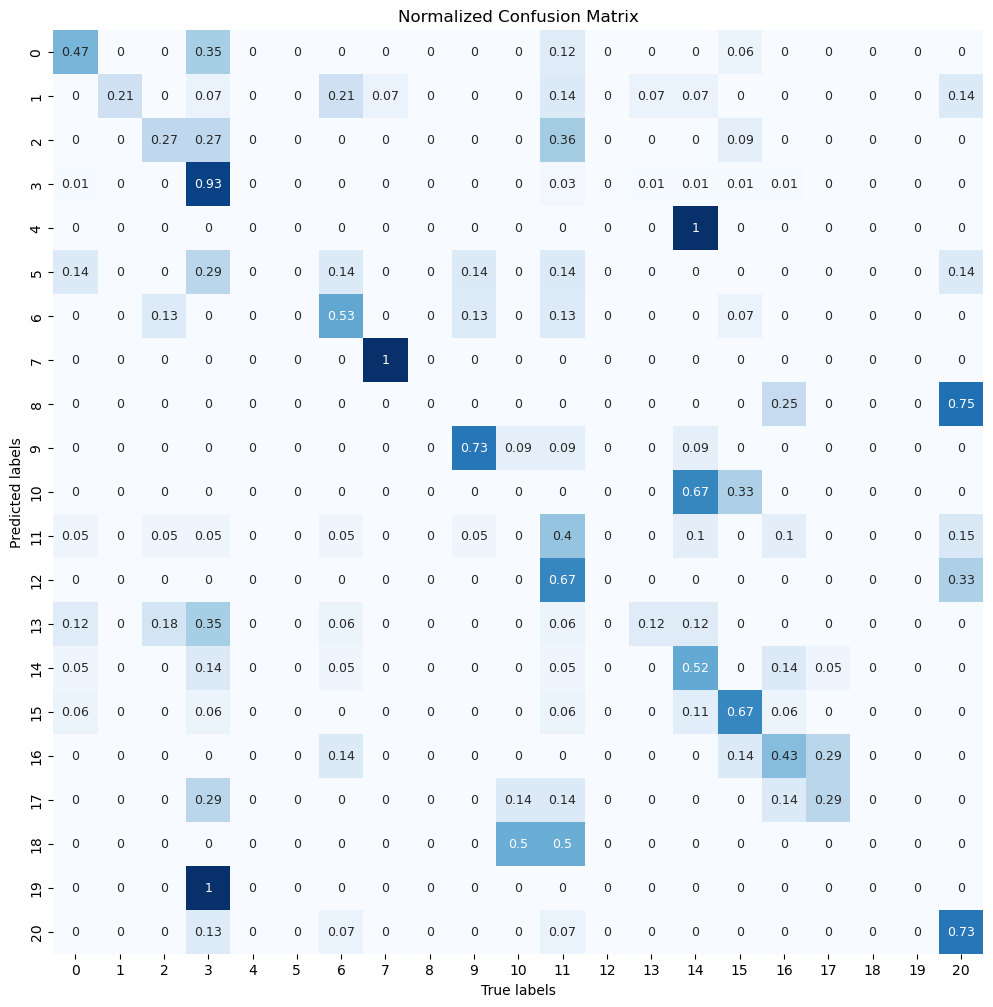

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# First, accumulate predictions and true labels from the test dataset.
true_labels = []
pred_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        # Ensure labels are tensors and in the correct type
        labels = torch.tensor(labels, device=device, dtype=torch.long)
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Save predictions and true labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute the confusion matrix from the true and predicted labels.
conf_metric = confusion_matrix(true_labels, pred_labels)

# Normalize the confusion matrix by dividing each row by its sum (i.e., relative percentages).
conf_metric_normalized = conf_metric / np.sum(conf_metric, axis=1, keepdims=True)

# Plot the confusion matrix using Seaborn.
plt.figure(figsize=[12,12], dpi=100)
sns.heatmap(np.round(conf_metric_normalized, 2),
            cbar=False,
            annot=True,
            annot_kws={"size": 9},
            cmap=plt.cm.Blues)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Normalized Confusion Matrix')
plt.show()